In [1]:
 # %pip install mplhep uproot

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.7.5-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.2 MB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda112, which is not installed.
cudf 21.10.1 requires cupy-cuda114, which is not installed.
scipy 1.6.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.4 which is incompatible.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.24.4 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but y

In [1]:
import uproot
import numpy as np
import os
import matplotlib.pyplot as plt
import mplhep as hep
import glob
from scipy.stats import beta

def clopper_pearson_interval(k, n, alpha=0.05):
    lower_bound = beta.ppf(alpha / 2, k, n - k + 1)
    upper_bound = beta.ppf(1 - alpha / 2, k + 1, n - k)
    return lower_bound, upper_bound


# Ntuple distribution checks

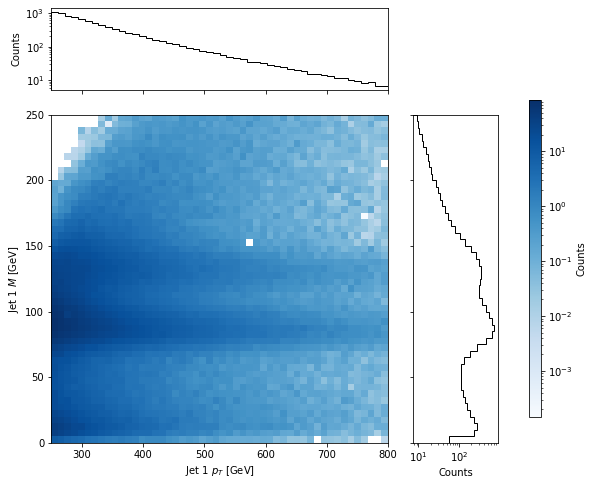

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm

# Function to load data
def load_data(file_paths):
    jet1_pt_list = []
    jet1_m_list = []
    weights_list = []

    
    for file_path in file_paths:
        file = uproot.open(file_path)
        tree = file["Nominal"]

        # Read the necessary branches
        jet1_pt = tree["Jet1_pT"].array(library="np")
        jet1_m = tree["Jet1_M"].array(library="np")
        weights = tree["weight"].array(library="np")  # Adjust this to your weight branch name

        
        jet1_pt_list.append(jet1_pt)
        jet1_m_list.append(jet1_m)
        weights_list.append(weights)
        
        
    jet1_pt = np.concatenate(jet1_pt_list)
    jet1_m = np.concatenate(jet1_m_list)
    weights = np.concatenate(weights_list)

    return jet1_pt, jet1_m, weights

# Specify the base path
base_path = "/fs/ddn/sdf/group/atlas"

# List of input paths
input_paths = [
    "d/zzheng/ggH/ntuple_triggerTest/mc20e/VH.root",
    "d/zzheng/ggH/ntuple_triggerTest/mc20d/VH.root",
    "d/zzheng/ggH/ntuple_triggerTest/mc20a/VH.root"
]

# Generate full file paths
file_paths = [os.path.join(base_path, path) for path in input_paths]


# Load data
jet1_pt, jet1_m, weights = load_data(file_paths)

# Create the corner plot
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], wspace=0.12, hspace=0.12)

# Axis limits
pt_min, pt_max = 250, 800  # Set your desired limits for Jet1_pT
m_min, m_max = 0, 250     # Set your desired limits for Jet1_M


# Top-left: 1D distribution of Jet1_pT
ax_hist_pt = plt.subplot(gs[0, 0])
ax_hist_pt.hist(jet1_pt, bins=50, range=(pt_min, pt_max), histtype='step', color='black',weights=weights)
ax_hist_pt.set_xlim(pt_min, pt_max)
ax_hist_pt.set_ylabel('Counts')
ax_hist_pt.set_yscale('log')  # Set y-axis to log scale
ax_hist_pt.tick_params(axis='x', labelbottom=False)

# Center: 2D distribution of Jet1_pT vs Jet1_M
ax_scatter = plt.subplot(gs[1, 0])
h, xedges, yedges = np.histogram2d(jet1_pt, jet1_m, bins=[50, 50], range=[[pt_min, pt_max], [m_min, m_max]],weights=weights)
im = ax_scatter.imshow(h.T, origin='lower', aspect='auto', extent=[pt_min, pt_max, m_min, m_max], cmap='Blues', norm=LogNorm())  # Changed to heatmap with log scale
ax_scatter.set_xlim(pt_min, pt_max)
ax_scatter.set_ylim(m_min, m_max)
ax_scatter.set_xlabel(r'Jet 1 $p_T$ [GeV]')
ax_scatter.set_ylabel(r'Jet 1 $M$ [GeV]')

# Bottom-right: 1D distribution of Jet1_M
ax_hist_m = plt.subplot(gs[1, 1])
ax_hist_m.hist(jet1_m, bins=50, range=(m_min, m_max), histtype='step', orientation='horizontal', color='black',weights=weights)
ax_hist_m.set_ylim(m_min, m_max)
ax_hist_m.set_xlabel('Counts')
ax_hist_m.set_xscale('log')  # Set x-axis to log scale
ax_hist_m.tick_params(axis='y', labelleft=False)

# Add color bar to the right of all plots
cbar_ax = fig.add_axes([0.955, 0.17, 0.02, 0.55])  # [left, bottom, width, height]
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('Counts')

plt.savefig(f"VH_Jet1_M_vs_pT.pdf")

plt.show()

# Efficiency vs pT

In [3]:
mass_cut = 0

def load_data_with_cuts_pT(file_paths):
    jet1_pt_list = []
    pass_hlt_dict = {}
    nMuons_list = []
    nLargeRJets_list = []
    Jet1_M_list = []
    weights_list = []

    for file_path in file_paths:
        # Open the ROOT file and read the tree
        file = uproot.open(file_path)
        
        # Check if the "Nominal" tree is in the file
        if "Nominal" not in file:
            print(f"Skipping file {file_path} because it does not contain a 'Nominal' tree.")
            continue        
        
        tree = file["Nominal"]
        
        # Read the necessary branches
        jet1_pt = tree["Jet1_pT"].array(library="np")
        nMuons = tree["nMuons"].array(library="np")
        nLargeRJets = tree["nLargeRJets"].array(library="np")
        Jet1_M = tree["Jet1_M"].array(library="np")
        weights = tree["weight"].array(library="np")  
        
        # Define selection cuts (e.g., nMuons > 0 and Jet1_M > 100)
        selection_mask = (nMuons >= 0) & (nLargeRJets>=1) & (Jet1_M > mass_cut)

        # Apply the selection mask to the data
        jet1_pt_list.append(jet1_pt[selection_mask])
        nMuons_list.append(nMuons[selection_mask])
        nLargeRJets_list.append(nLargeRJets[selection_mask])
        Jet1_M_list.append(Jet1_M[selection_mask])
        weights_list.append(weights[selection_mask])


        # Read all branches starting with "passHLT_" and apply the mask
        for branch in tree.keys():
            if branch.startswith("passHLT_"):
                #if "INF" not in branch:
                if "_" not in branch:     
                    continue # Skip branches that do not contain "INF"
                else:    
                    if branch not in pass_hlt_dict:
                        pass_hlt_dict[branch] = []
                    pass_hlt_dict[branch].append(tree[branch].array(library="np")[selection_mask])



    # Combine arrays from different files
    jet1_pt = np.concatenate(jet1_pt_list)
    weights = np.concatenate(weights_list)

    for key in pass_hlt_dict.keys():
        pass_hlt_dict[key] = np.concatenate(pass_hlt_dict[key])

    return jet1_pt, weights, pass_hlt_dict



In [4]:
def calculate_efficiency_pT(pass_hlt, jet1_pt,weights, thresholds):
    efficiency = []
    lower_errors = []
    upper_errors = []

    for threshold in thresholds:
        #passing_events = np.sum((jet1_pt > threshold) & (pass_hlt == 1))
        #total_events = np.sum(jet1_pt > threshold)
        
        selection_mask = jet1_pt > threshold
        passing_mask = (jet1_pt > threshold) & (pass_hlt == 1)

        total_events = np.sum(weights[selection_mask])
        passing_events = np.sum(weights[passing_mask])        
        
        
        if total_events > 0:
            eff = passing_events / total_events
            #err = np.sqrt(eff * (1 - eff) / total_events)
            #efficiency.append(eff)
            #errors.append(err)
            lower, upper = clopper_pearson_interval(passing_events, total_events)
            efficiency.append(eff)
            lower_errors.append(eff - lower)
            upper_errors.append(upper - eff)
            
        else:
            efficiency.append(0)
            #errors.append(0)
            lower_errors.append(0)
            upper_errors.append(0)

    return np.array(efficiency),np.array(lower_errors), np.array(upper_errors)


In [5]:

def trigger_efficiency_pT(input_path,textlabel):
    # Set the ATLAS Style
    hep.style.use("ATLAS")

    # Specify the base path directly
    base_path = "/fs/ddn/sdf/group/atlas"

#     # Construct the full paths to the ROOT files
#     file_paths = [
#         #os.path.join(base_path, "d/zzheng/ggH/ntuple_triggerTest/mc20a/VH.root"),
#         #os.path.join(base_path, "d/zzheng/ggH/ntuple_triggerTest/mc20d/VH.root"),
#         os.path.join(base_path, "d/zzheng/ggH/ntuple_triggerTest/mc20e/VH.root")
#     ]
    

    # If input_path is a directory, find all matching .root files
    if os.path.isdir(os.path.join(base_path, input_path)):
        file_paths = glob.glob(os.path.join(base_path, input_path, "*.root"))
    else:
        file_paths = [os.path.join(base_path, input_path)]

    # Load data from ROOT files with selection cuts
    jet1_pt,weights, pass_hlt_dict = load_data_with_cuts_pT(file_paths)

    # Define thresholds for Jet1_pT
    thresholds = np.linspace(np.min(jet1_pt), 1000, 30)

    # Create a directory to store the efficiency plots
    os.makedirs("efficiency_plots_jet1_pT", exist_ok=True)

    # Colors for different triggers
    #colors = ['r', 'b', 'g', 'm', 'c', 'orange', 'violet', 'springgreen']
    colors = ['r', 'b', 'g', 'm', 'c', 'orange', 'violet', 'springgreen', 
          'yellow', 'brown', 'pink', 'grey', 'navy', 'lime', 'cyan', 
          'purple', 'teal', 'gold', 'darkred', 'lightblue']
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))
    #fig.tight_layout()

    
## full trigger list
#     triggers = [
#     "passHLT_2j330_a10t_lcw_jes_30smcINF_L1J100",
#     "passHLT_j70_j50_0eta490_invm1100j70_dphi20_deta40_L1MJJ_500_NFF",
#     "passHLT_j360_a10_lcw_sub_L1J100",
#     "passHLT_j390_a10t_lcw_jes_30smcINF_L1J100",
#     "passHLT_j420_a10_lcw_L1J100",
#     "passHLT_j420_a10r_L1J100",
#     "passHLT_j420_a10t_lcw_jes_35smcINF_L1J100",
#     "passHLT_j420_a10t_lcw_jes_35smcINF_L1SC111",
#     "passHLT_j420_a10t_lcw_jes_40smcINF_L1J100",
#     "passHLT_j440_a10t_lcw_jes_40smcINF_L1J100",
#     "passHLT_j440_a10t_lcw_jes_L1J100",
#     "passHLT_j460_a10_lcw_subjes_L1J100",
#     "passHLT_j460_a10r_L1J100",
#     "passHLT_j460_a10t_lcw_jes_L1J100",
#     "passHLT_j480_a10_lcw_subjes_L1J100",
#     "passHLT_j480_a10r_L1J100",
#     "passHLT_j480_a10t_lcw_jes_L1J100"
#             ]   
    
        
    triggers_mc20a = [
    "passHLT_j420_a10_lcw_L1J100", 
    "passHLT_j420_a10r_L1J100",    
    "passHLT_j460_a10r_L1J100",
    "passHLT_j480_a10r_L1J100"
                ]    

        
    triggers_mc20d = [
    "passHLT_j390_a10t_lcw_jes_30smcINF_L1J100",
    "passHLT_j420_a10r_L1J100",
    "passHLT_j420_a10t_lcw_jes_40smcINF_L1J100",
    "passHLT_j440_a10t_lcw_jes_L1J100",
    "passHLT_j440_a10t_lcw_jes_40smcINF_L1J100",
    "passHLT_j460_a10_lcw_subjes_L1J100",
    "passHLT_j460_a10r_L1J100",
    "passHLT_j460_a10t_lcw_jes_L1J100",
    "passHLT_j480_a10_lcw_subjes_L1J100",
    "passHLT_j480_a10r_L1J100",
    "passHLT_j480_a10t_lcw_jes_L1J100"
            ]        
   
        
    triggers_mc20e = [
    "passHLT_j420_a10t_lcw_jes_35smcINF_L1J100",
    "passHLT_j420_a10t_lcw_jes_35smcINF_L1SC111",
    "passHLT_j460_a10_lcw_subjes_L1J100",
    "passHLT_j460_a10r_L1J100",
    "passHLT_j460_a10t_lcw_jes_L1J100",
            ]    
    
    # Plot efficiency for each passHLT branch containing "INF"
    for idx, (branch, pass_hlt) in enumerate(pass_hlt_dict.items()):
        #if "INF" in branch:
        
        #if "_" in branch:     
        #    #efficiency, errors = calculate_efficiency_pT(pass_hlt, jet1_pt, weights, thresholds)
        #    efficiency, lower_errors, upper_errors = calculate_efficiency_pT(pass_hlt, jet1_pt, weights, thresholds)
            

        if "mc20a" in textlabel and branch in triggers_mc20a:
            efficiency, lower_errors, upper_errors = calculate_efficiency_pT(pass_hlt, jet1_pt, weights, thresholds)
        elif "mc20d" in textlabel and branch in triggers_mc20d:
            efficiency, lower_errors, upper_errors = calculate_efficiency_pT(pass_hlt, jet1_pt, weights, thresholds)
        elif "mc20e" in textlabel and branch in triggers_mc20e:
            efficiency, lower_errors, upper_errors = calculate_efficiency_pT(pass_hlt, jet1_pt, weights, thresholds)
        else:
            continue  # Skip if branch is not in the corresponding trigger list            

             
        # Plot the graph with markers and error bars
        color = colors[idx % len(colors)]
        ax.errorbar(thresholds, efficiency, yerr=[lower_errors, upper_errors], fmt='o', label=f'{branch}', color=color)

        # Plot the line through the points
        ax.plot(thresholds, efficiency, color=color)
  
            
    # Set axis titles
    ax.set_xlabel("Jet1 $p_\mathcal{T}$")
    ax.set_ylabel('Trigger Efficiency')

    # Add the ATLAS Label
    #hep.atlas.text("Internal", loc=1)
    hep.atlas.label(loc=1,data='true',label="Internal",lumi=139)

    
    #ax.text(0.2, 0.86, "#sqrt{s} = 13 TeV, 139 fb^{-1}", fontsize=12, transform=ax.transAxes)

    # Add the mass cut text
    ax.text(0.05, 0.83, f"Jet1 M > {mass_cut} GeV", fontsize=14, transform=ax.transAxes)
    ax.text(0.05, 0.78, f"{textlabel}", fontsize=14, transform=ax.transAxes)

    # Add legend
    ax.legend(bbox_to_anchor=(0.92, 0.50),fontsize=10,loc='center right')
    #ax.legend(bbox_to_anchor=(0.55, 0.2, 0.85, 0.6),fontsize=14)

    # Save the plot as a PDF
    plt.savefig(f"efficiency_plots_jet1_pT/VH_{textlabel}.pdf")

    print("Efficiency plots saved in the 'efficiency_plots_jet1_pT' directory.")

    


## mc20a

In [6]:
trigger_efficiency_pT(input_path="d/zzheng/ggH/ntuple_triggerTest/mc20a/VH.root",textlabel="mc20a")

AttributeError: module 'mplhep.styles' has no attribute 'use'

## mc20d

In [7]:
trigger_efficiency_pT(input_path="d/zzheng/ggH/ntuple_triggerTest/mc20d/VH.root",textlabel="mc20d")

AttributeError: module 'mplhep.styles' has no attribute 'use'

## mc20e

In [8]:
trigger_efficiency_pT(input_path="d/zzheng/ggH/ntuple_triggerTest/mc20e/VH.root",textlabel="mc20e")

AttributeError: module 'mplhep.styles' has no attribute 'use'

# Efficiency vs M

In [ ]:
pT_cut = 500

def load_data_with_cuts_M(file_paths):
    jet1_pt_list = []
    pass_hlt_dict = {}
    nMuons_list = []
    nLargeRJets_list = []
    Jet1_M_list = []
    weights_list = []

    for file_path in file_paths:
        # Open the ROOT file and read the tree
        file = uproot.open(file_path)
        tree = file["Nominal"]

        # Read the necessary branches
        jet1_pt = tree["Jet1_pT"].array(library="np")
        nMuons = tree["nMuons"].array(library="np")
        nLargeRJets = tree["nLargeRJets"].array(library="np")
        Jet1_M = tree["Jet1_M"].array(library="np")
        weights = tree["weight"].array(library="np")  # Adjust this to your weight branch name

        # Define selection cuts (e.g., nMuons > 0 and Jet1_M > 100)
        selection_mask = (nMuons >= 0) & (jet1_pt > pT_cut)

        # Apply the selection mask to the data
        jet1_pt_list.append(jet1_pt[selection_mask])
        nMuons_list.append(nMuons[selection_mask])
        nLargeRJets_list.append(nLargeRJets[selection_mask])
        Jet1_M_list.append(Jet1_M[selection_mask])
        weights_list.append(weights[selection_mask])

        # Read all branches starting with "passHLT_" and apply the mask
        for branch in tree.keys():
            if branch.startswith("passHLT_"):
                if "_" not in branch:
                #if "INF" not in branch:
                    continue # Skip branches that do not contain "INF"
                else:    
                    if branch not in pass_hlt_dict:
                        pass_hlt_dict[branch] = []
                    pass_hlt_dict[branch].append(tree[branch].array(library="np")[selection_mask])

    # Combine arrays from different files
    jet1_M = np.concatenate(Jet1_M_list)
    weights = np.concatenate(weights_list)

    for key in pass_hlt_dict.keys():
        pass_hlt_dict[key] = np.concatenate(pass_hlt_dict[key])

    return jet1_M, weights, pass_hlt_dict


In [ ]:
def calculate_efficiency_M(pass_hlt, jet1_M,weights, thresholds):
    efficiency = []
    lower_errors = []
    upper_errors = []

    for threshold in thresholds:
        #passing_events = np.sum((jet1_pt > threshold) & (pass_hlt == 1))
        #total_events = np.sum(jet1_pt > threshold)
        
        selection_mask = jet1_M > threshold
        passing_mask = (jet1_M > threshold) & (pass_hlt == 1)

        total_events = np.sum(weights[selection_mask])
        passing_events = np.sum(weights[passing_mask])        
        
        
        if total_events > 0:
            eff = passing_events / total_events
            #err = np.sqrt(eff * (1 - eff) / total_events)
            #efficiency.append(eff)
            #errors.append(err)
            lower, upper = clopper_pearson_interval(passing_events, total_events)
            efficiency.append(eff)
            lower_errors.append(eff - lower)
            upper_errors.append(upper - eff)
            
        else:
            efficiency.append(0)
            #errors.append(0)
            lower_errors.append(0)
            upper_errors.append(0)

    return np.array(efficiency),np.array(lower_errors), np.array(upper_errors)


In [ ]:
def trigger_efficiency_M(input_path,textlabel):
    # Set the ATLAS Style
    hep.style.use("ATLAS")

    # Specify the base path directly
    base_path = "/fs/ddn/sdf/group/atlas"

#     # Construct the full paths to the ROOT files
#     file_paths = [
#         #os.path.join(base_path, "d/zzheng/ggH/ntuple_triggerTest/mc20a/VH.root"),
#         #os.path.join(base_path, "d/zzheng/ggH/ntuple_triggerTest/mc20d/VH.root"),
#         os.path.join(base_path, "d/zzheng/ggH/ntuple_triggerTest/mc20e/VH.root")
#     ]
    
  

    # If input_path is a directory, find all matching .root files
    if os.path.isdir(os.path.join(base_path, input_path)):
        file_paths = glob.glob(os.path.join(base_path, input_path, "*.root"))
    else:
        file_paths = [os.path.join(base_path, input_path)]

    # Load data from ROOT files with selection cuts
    jet1_M,weights, pass_hlt_dict = load_data_with_cuts_M(file_paths)

    # Define thresholds for Jet1_pT
    thresholds = np.linspace(0, 450, 30)

    # Create a directory to store the efficiency plots
    os.makedirs("efficiency_plots_jet1_M", exist_ok=True)

    # Colors for different triggers
    colors = ['r', 'b', 'g', 'm', 'c', 'orange', 'violet', 'springgreen', 
              'yellow', 'brown', 'pink', 'grey', 'navy', 'lime', 'cyan', 
              'purple', 'teal', 'gold', 'darkred', 'lightblue']
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))
    #fig.tight_layout()

    
         
       
    triggers_mc20a = [
    "passHLT_j420_a10_lcw_L1J100", 
    "passHLT_j420_a10r_L1J100",    
    "passHLT_j460_a10r_L1J100",
    "passHLT_j480_a10r_L1J100"
                ]    

        
    triggers_mc20d = [
    "passHLT_j390_a10t_lcw_jes_30smcINF_L1J100",
    "passHLT_j420_a10r_L1J100",
    "passHLT_j420_a10t_lcw_jes_40smcINF_L1J100",
    "passHLT_j440_a10t_lcw_jes_L1J100",
    "passHLT_j440_a10t_lcw_jes_40smcINF_L1J100",
    "passHLT_j460_a10_lcw_subjes_L1J100",
    "passHLT_j460_a10r_L1J100",
    "passHLT_j460_a10t_lcw_jes_L1J100",
    "passHLT_j480_a10_lcw_subjes_L1J100",
    "passHLT_j480_a10r_L1J100",
    "passHLT_j480_a10t_lcw_jes_L1J100"
            ]        
   
        
    triggers_mc20e = [
    "passHLT_j420_a10t_lcw_jes_35smcINF_L1J100",
    "passHLT_j420_a10t_lcw_jes_35smcINF_L1SC111",
    "passHLT_j460_a10_lcw_subjes_L1J100",
    "passHLT_j460_a10r_L1J100",
    "passHLT_j460_a10t_lcw_jes_L1J100",
            ]    

    # Plot efficiency for each passHLT branch containing "INF"
    for idx, (branch, pass_hlt) in enumerate(pass_hlt_dict.items()):
        #if "INF" in branch:
        #if "_" in branch: #trick to plot all triggers
            #efficiency, errors = calculate_efficiency_pT(pass_hlt, jet1_pt, weights, thresholds)
            #efficiency, lower_errors, upper_errors = calculate_efficiency_M(pass_hlt, jet1_M, weights, thresholds)
        
        if "mc20a" in textlabel and branch in triggers_mc20a:
            efficiency, lower_errors, upper_errors = calculate_efficiency_M(pass_hlt, jet1_M, weights, thresholds)
        elif "mc20d" in textlabel and branch in triggers_mc20d:
            efficiency, lower_errors, upper_errors = calculate_efficiency_M(pass_hlt, jet1_M, weights, thresholds)
        elif "mc20e" in textlabel and branch in triggers_mc20e:
            efficiency, lower_errors, upper_errors = calculate_efficiency_M(pass_hlt, jet1_M, weights, thresholds)
        else:
            continue  # Skip if branch is not in the corresponding trigger list            

        # Plot the graph with markers and error bars
        color = colors[idx % len(colors)]
        ax.errorbar(thresholds, efficiency, yerr=[lower_errors, upper_errors], fmt='o', label=f'{branch}', color=color)

        # Plot the line through the points
        ax.plot(thresholds, efficiency, color=color)

    # Set axis titles
    ax.set_xlabel("Jet1 M [GeV]")
    ax.set_ylabel('Trigger Efficiency')
    ax.set_ylim(0.3,1.2)
    # Add the ATLAS Label
    #hep.atlas.text("Internal", loc=1)
    hep.atlas.label(loc=1,data='true',label="Internal",lumi=139)

    #ax.text(0.2, 0.86, "#sqrt{s} = 13 TeV, 139 fb^{-1}", fontsize=12, transform=ax.transAxes)

    
    # Add the mass cut text
    #ax.text(0.2, 0.80, f"Mass Cut: nMuons >= 0 & Jet1_M > {mass_cut}", fontsize=12, transform=ax.transAxes)
    ax.text(0.05, 0.83, f"Jet1 $p_T$ > {pT_cut} GeV", fontsize=14, transform=ax.transAxes)
    ax.text(0.05, 0.78, f"{textlabel}", fontsize=14, transform=ax.transAxes)

    
    # Add legend
    ax.legend(bbox_to_anchor=(0.92, 0.30),fontsize=10,loc='center right')
    #ax.legend(bbox_to_anchor=(0.55, 0.2, 0.85, 0.6),fontsize=14)

    # Save the plot as a PDF
    plt.savefig(f"efficiency_plots_jet1_M/VH_{textlabel}.pdf")
    
    print("Efficiency plots saved in the 'efficiency_plots_jet1_M' directory.")


## mc20a


In [ ]:
trigger_efficiency_M(input_path="d/zzheng/ggH/ntuple_triggerTest/mc20a/VH.root",textlabel="mc20a")

## mc20d


In [ ]:
trigger_efficiency_M(input_path="d/zzheng/ggH/ntuple_triggerTest/mc20d/VH.root",textlabel="mc20d")



## mc20e




In [ ]:
trigger_efficiency_M(input_path="d/zzheng/ggH/ntuple_triggerTest/mc20e/VH.root",textlabel="mc20e")